

copy of 39



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm
import rasterio as rio

from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points

In [2]:
# Load ice base interpolated from radar results
direc = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/interpolatedgrid_allchan'

xv = np.load(direc + 'x_grid' +'.npy')
yv = np.load(direc + 'y_grid' +'.npy')
thickness_interpolated = np.load(direc +'ice_thickness'+'.npy')
extent_l2l = np.load(direc +'extent.npy')
ice_base = np.load(direc +'_ice_base.npy')
ice_base_smooth = sp.ndimage.gaussian_filter(ice_base, sigma=30, order=0)

#pre interpolation
x_o = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/smooth4_mitgcm_x.npy')
y_o = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/smooth4_mitgcm_y.npy')
ib_o = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/smooth4_mitgcm_icebase.npy')

#background without
background_cc_path = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/smooth_mitgcm_ice_base_no_chan.pkl'
# background_cut_chan = pd.read_pickle('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/ice_base_no_chan.pkl')

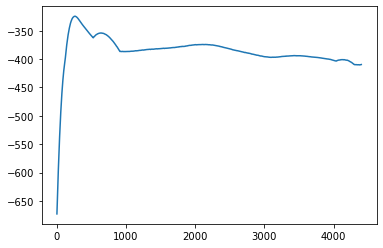

In [58]:
plt.plot(np.amax(ib_o,axis=0))

In [3]:
xmax = np.max(x_o) + 300
xmin = np.min(x_o) - 300
ymax = np.max(y_o) + 300
ymin = np.min(y_o) - 300

In [16]:
background_cut_chan = pd.read_pickle(background_cc_path).query(f' x > {xmin} & x < {xmax} & y > {ymin} & y < {ymax}').copy()

In [17]:
background_cut_chan.keys()

Index(['x', 'y', 'ice_thickn', 'geometry'], dtype='object')

In [18]:
x_a = np.concatenate((x_o.flatten(),  background_cut_chan.x.to_numpy() ))

In [19]:
y_a = np.concatenate((y_o.flatten(),  background_cut_chan.y.to_numpy() ))

In [20]:
#67.36358 is mean of REMA tiff (see 05_foursquare plots)
background_baseheight = 67.36358 - background_cut_chan.ice_thickn.mean()

ib_out_of_channel = background_baseheight*np.ones(background_cut_chan.shape[0])

# ib_out_of_channel = background_cut_chan.ib.to_numpy()

In [21]:
background_baseheight

-592.2350297867519

In [22]:
ib_a = np.concatenate((ib_o.flatten(),  ib_out_of_channel ))

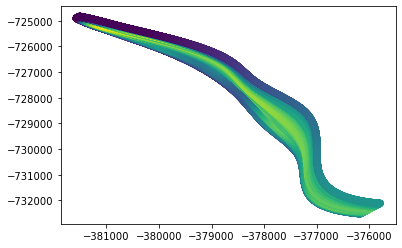

In [23]:
plt.scatter(x_o,y_o,c=ib_o)

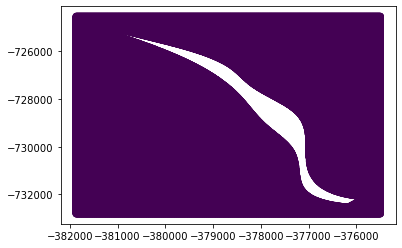

In [24]:
plt.scatter(background_cut_chan.x,background_cut_chan.y,c=ib_out_of_channel)

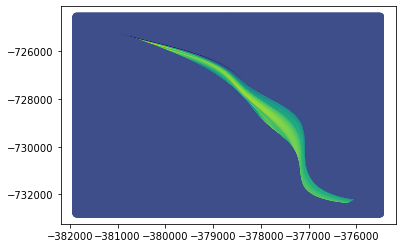

In [25]:
plt.scatter(x_a,y_a,c=ib_a)

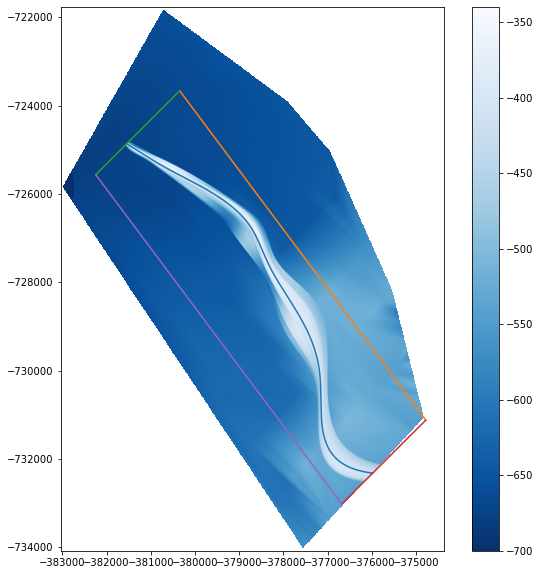

In [26]:


plt.figure(figsize=(10,10))
plt.imshow(ice_base,extent=extent_l2l,cmap='Blues_r',vmin=-700,vmax=-340)
plt.colorbar()
plt.plot(x_o[50,:],y_o[50,:])

#draw a box
r = 1200
b = 700
top = [x_o[50,0]+r,y_o[50,0]+r]
left = [x_o[50,0]-b,y_o[50,0]-b]
bottom  = [x_o[50,-1]-b,y_o[50,-1]-b]
right  = [x_o[50,-1]+r,y_o[50,-1]+r]

plt.plot([top[0],right[0]],[top[1],right[1]])
plt.plot([top[0],left[0]],[top[1],left[1]])
plt.plot([bottom[0],right[0]],[bottom[1],right[1]])
plt.plot([bottom[0],left[0]],[bottom[1],left[1]])


plt.show()

In [27]:
print(left,top, right,bottom )

[-382247.5016733403, -725561.4470406986] [-380347.5016733403, -723661.4470406986] [-374776.4773078364, -731116.6223268493] [-376676.4773078364, -733016.6223268493]


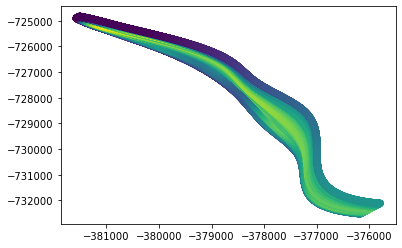

In [28]:
plt.scatter(x_o,y_o,c=ib_o)

## rotate

$x' = x \cos\theta + y \sin \theta$

$y' = -x \sin\theta + y \cos \theta$

In [29]:
theta = np.arctan((y_o[-1,-1]-y_o[-1,0])/(x_o[-1,-1]-x_o[-1,0]))
theta

-0.9057083112623254

In [30]:
x_r = x_o*np.cos(theta) + y_o*np.sin(theta)
y_r = -x_o*np.sin(theta) + y_o*np.cos(theta)



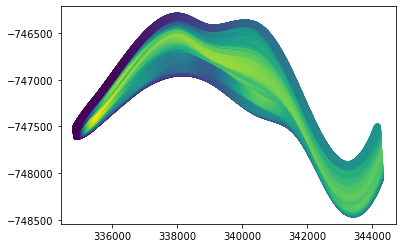

In [31]:
plt.scatter(x_r,y_r,c=ib_o)

## translate 
translate: minus x and y from left 

In [32]:
x_tr = x_r - np.amin(x_r)
y_tr = y_r - np.amin(y_r)

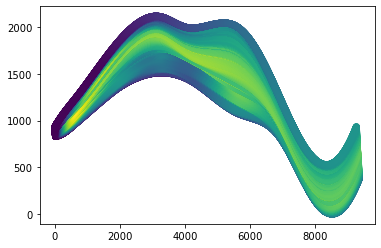

In [33]:
plt.scatter(x_tr,y_tr,c=ib_o)

In [34]:
lx = x_tr.max()
ly = y_tr.max()

# with background

In [35]:
#rotate
x_ra = x_a*np.cos(theta) + y_a*np.sin(theta)
y_ra = -x_a*np.sin(theta) + y_a*np.cos(theta)



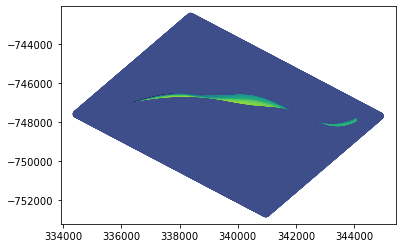

In [36]:
plt.scatter(x_ra,y_ra,c=ib_a)

In [37]:
#translate
x_tra = x_ra - np.amin(x_r)
y_tra = y_ra - np.amin(y_r)

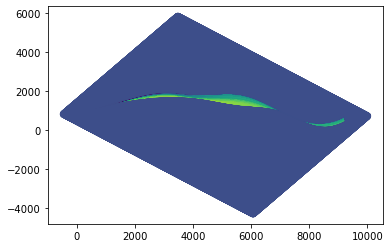

In [38]:
plt.scatter(x_tra,y_tra,c=ib_a)

In [39]:
reduce_it = pd.DataFrame({'x':x_tra, 'y':y_tra, 'ib':ib_a}).query(f'x< {lx} & x>0 & y < {ly} & y> 0')

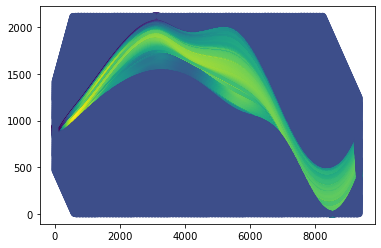

In [40]:
plt.scatter(reduce_it.x,reduce_it.y,c=reduce_it.ib)

In [3]:
cut_start = 4
cut_end = -3

In [92]:
x_resA = 200+ abs(cut_end) + cut_start 
y_resA = 100 -2 #2 for more deadspace top and bottom

xv, yv = np.meshgrid(np.linspace(0,lx,x_resA), np.linspace(ly,0,y_resA))

In [93]:
xv[:,cut_start:cut_end].shape

(98, 200)

In [94]:
ib_interp = sp.interpolate.griddata(np.array([reduce_it.x.to_numpy(),reduce_it.y.to_numpy()]).T,reduce_it.ib,(xv, yv),method='nearest')

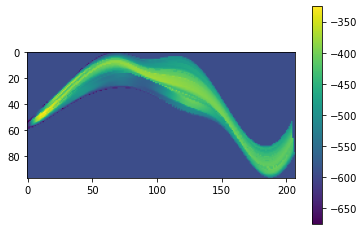

In [95]:
plt.figure()
plt.imshow(ib_interp)
plt.colorbar()

# redo back to match edges of channel

In [96]:
#non constant background
# for i in range(x_resA):
#     mn = np.min(ib_interp[:,i])
#     ib_interp[:,i][ib_interp[:,i]==background_baseheight] = mn

In [97]:
#constant background
bh = np.min(ib_interp[:,0])
ib_interp[ib_interp==background_baseheight] = bh

In [98]:
ib_interp = np.vstack([bh*np.ones((ib_interp.shape[1])),ib_interp,bh*np.ones((ib_interp.shape[1]))])

In [99]:
ib_interp.shape

(100, 207)

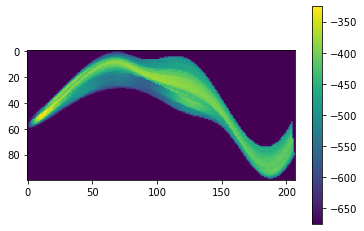

In [100]:
plt.figure()
plt.imshow(ib_interp)
plt.colorbar()

In [101]:
#smooth it
smoo = sp.ndimage.gaussian_filter(ib_interp, sigma=1, order=0)

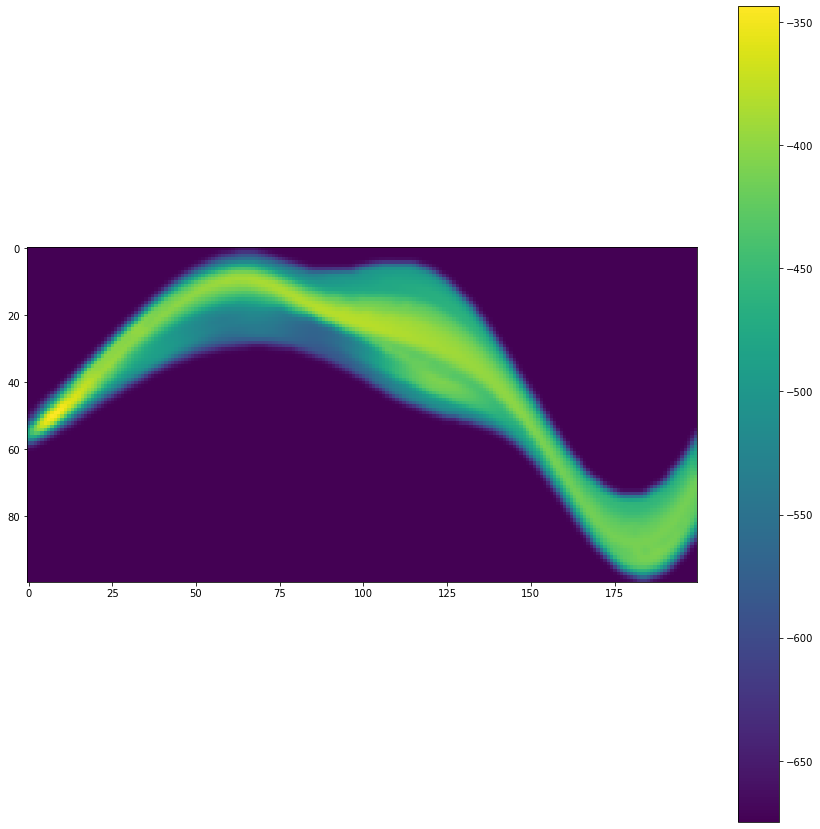

In [102]:
plt.figure(figsize=(15,15))
plt.imshow(smoo[:,cut_start:cut_end])
plt.colorbar()

# cut off the beg and end

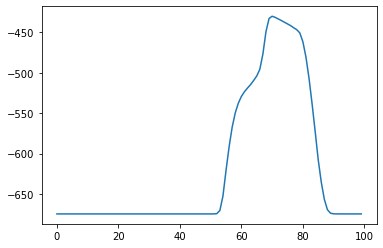

In [103]:
#end
plt.plot(smoo[:,cut_end])

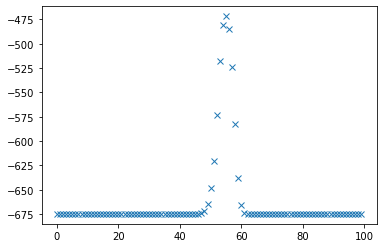

In [104]:
plt.plot(smoo[:,cut_start],'x')

In [105]:
smoo.shape

(100, 207)

In [106]:
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/smoo_ice_base_mitgcm.npy',ib_interp[:,cut_start:cut_end])
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/smoo_xv_mitgcm.npy',xv[:,cut_start:cut_end])
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/smoo_yv_mitgcm.npy',yv[:,cut_start:cut_end])
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/smoo_ice_base_smooth_mitgcm.npy',smoo[:,cut_start:cut_end])

In [5]:
xv[0,0]-xv[0,cut_start]

-8.0

In [10]:
xv[0,cut_end]-xv[0,-1]

-4.0

In [11]:
np.diff(xv[0,:])

array([2., 2., 2., ..., 2., 2., 2.])